# Computer Vision Project 3 - Facemask Applayer

* Wojciech Wieczorek 145465
* Jerzy Łukaszewicz 145458
<p>
<a>https://github.com/Wo0kie3/CVprojekt3

### Problem description

We chose Object detection and classification with image augmentation. Our program searches for faces and classifies them to mask/no_mask class. For each face with no_mask class we modify the original image adding a facemask to cover mouth and nose.

## Prerequisites

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import cv2
import copy
import glob
import os

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense,Conv2D, Input, Flatten,Dropout,AveragePooling2D,MaxPooling2D,BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical

In [3]:
import imutils
from imutils import face_utils

import dlib

# Data preparation

### Description of the data

Our data cointains labeled images of people faces covered with facemasks or without them, split into separate folders.

## Importing data

Testing and training sets are located in <code>./data</code> folder

In [4]:
train_mask = glob.glob('data/train/mask/*.jpg')
train_no_mask = glob.glob('data/train/no_mask/*.jpg')
test_mask = glob.glob('data/test/mask/*.jpg')
test_no_mask = glob.glob('data/test/no_mask/*.jpg')

## Spliting data into training, validation and testing sets

Shuffling both training and test sets

In [5]:
np.random.shuffle(train_mask)
np.random.shuffle(train_no_mask)

We also seperate out validation set from big training set, then prepare arrays with target classes

In [6]:
val_mask = train_mask[555:]
val_no_mask = train_mask[555:]

train_mask = train_mask[:555]
train_no_mask = train_no_mask[:555]

X_train = np.array([preprocess_input(img_to_array(load_img(img, target_size=(224, 224)))) for img in train_mask + train_no_mask])
y_train = np.array([label for label in ['mask'] * len(train_mask) + ['no_mask'] * len(train_no_mask)])

X_val = np.array([preprocess_input(img_to_array(load_img(img, target_size=(224, 224)))) for img in val_mask + val_no_mask])
y_val = np.array([label for label in ['mask'] * len(val_mask) + ['no_mask'] * len(val_no_mask)])

X_test = np.array([preprocess_input(img_to_array(load_img(img, target_size=(224, 224)))) for img in test_mask + test_no_mask])
y_test = np.array([label for label in ['mask'] * len(test_mask) + ['no_mask'] * len(test_no_mask)])

In [7]:
print('Set sizes: train: {}, val: {}, test: {}'.format(len(X_train), len(X_val), len(X_test)))

Set sizes: train: 1110, val: 246, test: 202


Example image:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


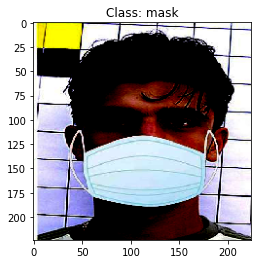

In [8]:
plt.imshow(X_train[77])
plt.title("Class: " + y_train[77])
plt.show()

## Preprocesing

We transform target class with <a href='https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html'>OneHotEncoder</a>

In [9]:
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(y_train.reshape(-1,1))

y_train = ohe.transform(y_train.reshape(-1,1)).toarray()
y_val = ohe.transform(y_val.reshape(-1,1)).toarray()
y_test = ohe.transform(y_test.reshape(-1,1)).toarray()

# Image classification model

## Defining image data generator

<a href='https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator'>ImageDataGenerator</a> will be usful for fetching moderately transformed images during model's learning process

In [10]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

## Defining model structure

Model takes images of size 224x244 and 3 color chanels. It is made of 3 convolutional blocks each consisting of 2D-convolutional layer with ReLU as activation function and 2D-max-pooling layer. After that processing takes place we transform the output of last convolutional layer to one dimensional vector on which we feed to Dense layer with ReLU activation function. Then we perform dropout with rate 0.5. At the end we transform the output into vector of probabilities indicating which class should be assingned to the image.

In [11]:
model = keras.Sequential()

After experimenting with different parameters these ones provided the best results for our model.

In [12]:
model.add(Input(shape=(224,224,3)))

model.add(Conv2D(64, (3, 3), input_shape=(224, 224, 3),activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3),activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3),activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(32,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation="softmax"))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 32)       0

In [15]:
INIT_LR = 1e-4 #initial learning rate
EPOCHS = 30 #number of epochs
BS = 32 # batch size

We had to provide our own metrics functions because TensorFlow build-in metrics functions were not applicable for our problem (for one-hot encoding values of precision, recal and accuracy were the same each epoch).

In [14]:
def check_units(y_true, y_pred):
    if y_pred.shape[1] != 1:
        y_pred = y_pred[:,1:2]
        y_true = y_true[:,1:2]
    return y_true, y_pred

def precision(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [16]:
metrics = [keras.metrics.BinaryAccuracy(name='accuracy'),
           precision,
           recall]

In [17]:
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=metrics)

We train our model using images in augmented form (different zoom, rotation, shift...). We also provide early stopping for our model monitoring validation set loss to prevent our model from overfitting.

In [23]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [18]:
H = model.fit(
    aug.flow(X_train, y_train, batch_size=BS),
    steps_per_epoch=len(X_train) // BS,
    validation_data=(X_test, y_test),
    validation_steps=len(X_test) // BS,
    epochs=EPOCHS,
    callbacks=[es])

Epoch 1/30
34/34 [==============================] - 27s 759ms/step - loss: 0.6467 - accuracy: 0.6280 - precision: 0.6161 - recall: 0.6340 - val_loss: 0.4926 - val_accuracy: 0.8663 - val_precision: 0.4943 - val_recall: 0.4287
Epoch 2/30
34/34 [==============================] - 25s 743ms/step - loss: 0.4837 - accuracy: 0.8006 - precision: 0.7880 - recall: 0.8153 - val_loss: 0.2761 - val_accuracy: 0.9010 - val_precision: 0.4839 - val_recall: 0.4741
Epoch 3/30
34/34 [==============================] - 26s 753ms/step - loss: 0.3655 - accuracy: 0.8646 - precision: 0.8634 - recall: 0.8707 - val_loss: 0.2040 - val_accuracy: 0.9356 - val_precision: 0.4839 - val_recall: 0.4689
Epoch 4/30
34/34 [==============================] - 26s 747ms/step - loss: 0.3268 - accuracy: 0.8887 - precision: 0.8954 - recall: 0.8902 - val_loss: 0.1862 - val_accuracy: 0.9455 - val_precision: 0.4839 - val_recall: 0.4689
Epoch 5/30
34/34 [==============================] - 26s 748ms/step - loss: 0.3088 - accuracy: 0.8831

We save our model to  use it later without learing again.

In [32]:
model.save("mask_detector.model", save_format="h5")

Here we can find some statistics describing the performance of our model on the test set.

In [33]:
predIdxs = model.predict(X_test, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(y_test.argmax(axis=1), predIdxs,target_names=("mask","no_mask")))

              precision    recall  f1-score   support

        mask       0.96      0.94      0.95       105
     no_mask       0.94      0.96      0.95        97

    accuracy                           0.95       202
   macro avg       0.95      0.95      0.95       202
weighted avg       0.95      0.95      0.95       202



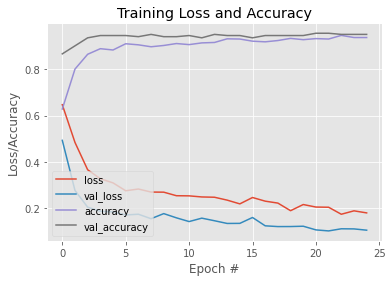

In [34]:
N = len(H.history["loss"])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="accuracy")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

We use predefined tensorFlow model for detecting faces on the images. It is implemented with dlib using HOG + SVM and CNN + Deep learning. <a>https://github.com/gopinath-balu/computer_vision/tree/master/CAFFE_DNN

In [11]:
prototxtPath = os.path.sep.join(["deploy.prototxt.txt"])
weightsPath = os.path.sep.join(["res10_300x300_ssd_iter_140000.caffemodel"])

In [12]:
net = cv2.dnn.readNet(prototxtPath, weightsPath)

Later we use dlib library to detect face keypoints on human face to correctly fit the facemask. <a>http://dlib.net/face_detector.py.html

In [17]:
model = load_model("mask_detector.model", custom_objects={"precision": precision,"recall":recall })
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

Shape predictor returns coordinates of 68 keypoints on human face.


<img src="https://media.discordapp.net/attachments/922552616611893318/939701626715922452/points.png" width="300" align ="left"/> 

We use points 1, 9, 17 to estimate width height and rotation for our facemask.

In [18]:
def applyMask(l_img, box):
    startX, startY, endX, endY = box
    startX = max(0,startX)
    startY = max(0,startY)
    endX = max(0,endX)
    endY = max(0,endY)
    gray = cv2.cvtColor(l_img[startY:endY,startX:endX], cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)
    if len(rects)==0:
        coords = np.array([[startX, (endY-startY) * 0.2],[(endX-startX) * 0.5,startY],[endX,(endY-startY) * 0.2]])
    else:
        shape = predictor(gray, rects[0])
        shape = face_utils.shape_to_np(shape)
        coords = shape[[0, 8, 16]]
    diff = coords[2] - coords[0]
    width = int(sum((diff) ** 2) ** (1/2))
    mid = (coords[0] + coords[2]) / 2
    angle = np.degrees(np.arctan2(diff[1], diff[0]))
    
    s_img = cv2.imread("./data/MASK2.png")
    s_img = imutils.resize(s_img, width=width)
    s_img = imutils.rotate_bound(s_img, angle)
    
    rows = [i for i, row in enumerate(s_img) if row.sum() == 0]
    columns = [i for i, col in enumerate(s_img.transpose(1, 0, 2)) if col.sum() == 0]

    s_img = np.delete(s_img, [rows], 0)
    s_img = np.delete(s_img.transpose(1, 0, 2), [columns], 0)
    s_img = s_img.transpose(1, 0, 2)

    if len(rects) != 0:
        x_offset=shape[51][0] - int(s_img.shape[1]/2)
        y_offset=shape[51][1] - int(s_img.shape[0]/2)
    else:
        x_offset = ((endX - startX)*0.5 - int(s_img.shape[1]/2))
        y_offset = ((endY - startY)*0.75 - int(s_img.shape[0]/2))
    
    y1, y2 = int(y_offset), int(y_offset) + s_img.shape[0]
    x1, x2 = int(x_offset), int(x_offset) + s_img.shape[1]

    for y in range(y1, y2):
        for x in range(x1, x2):
            try:
                l_img[y+startY-1, x+startX-1] = s_img[y-y1, x-x1] if sum(s_img[y-y1, x-x1]) != 0 else l_img[y+startY-1, x+startX-1]
            except:
                continue
    return l_img[startY:endY,startX:endX]

The detection function provides the squeres where face was detected. We take into consideration only those predictions with confidence greater than 50%. Then we look at those parts of the picture where we are sure about "No Mask" class (there are also cases when we detect "Mask" class and "Indecisive" - when the diference in predicted probability is less then 20%. However we do nothing with them). We cut them of and look for keypoints which are further passed to applyMask function where we fit the mask to the face.

In [19]:
def imageProcessing(detections, image): 
    new_img = copy.deepcopy(image)
    for i in range(0, detections.shape[2]):

        confidence = detections[0, 0, i, 2]

        if confidence > 0.50:

            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
            face = image[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)
            face = np.expand_dims(face, axis=0)
            (mask, withoutMask) = model.predict(face)[0]
            if np.abs(mask-withoutMask) < 0.2:
                label = "Indecisive"
                color = (0,255,255)
            else:
                label = "Mask" if mask > withoutMask else "No Mask"
                color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
            if withoutMask >= 0.6:
                applyMask(new_img, box.astype("int"))

            label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

            cv2.putText(image, label, (startX, startY - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
            cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(16,9))        
    plt.imshow(np.hstack([image,new_img]))

In [20]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir('./data_test') if isfile(join('./data_test', f))]

## Results

Here are some examples of our model in action.

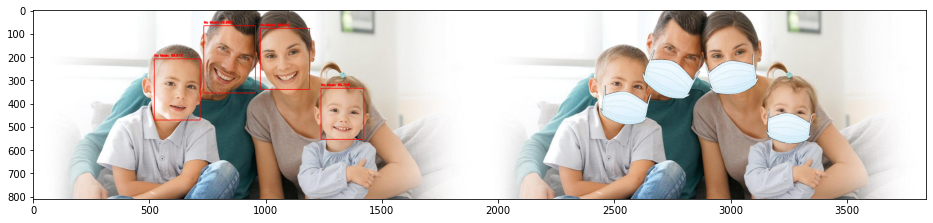

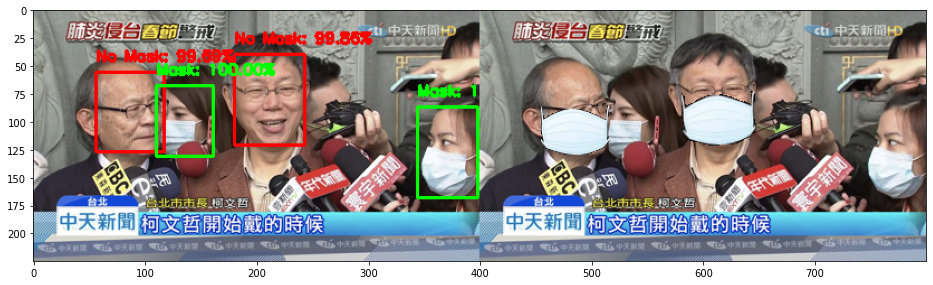

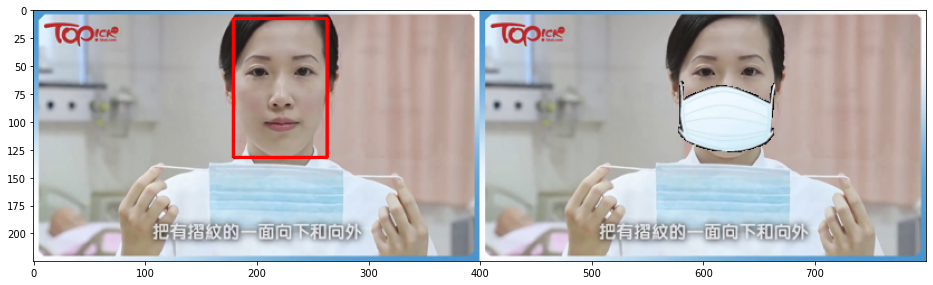

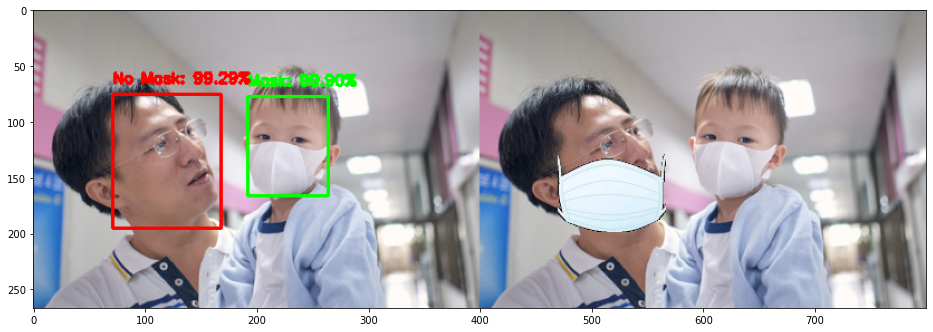

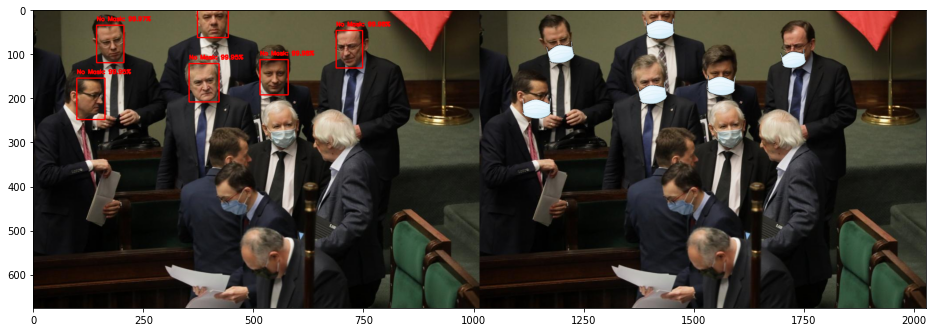

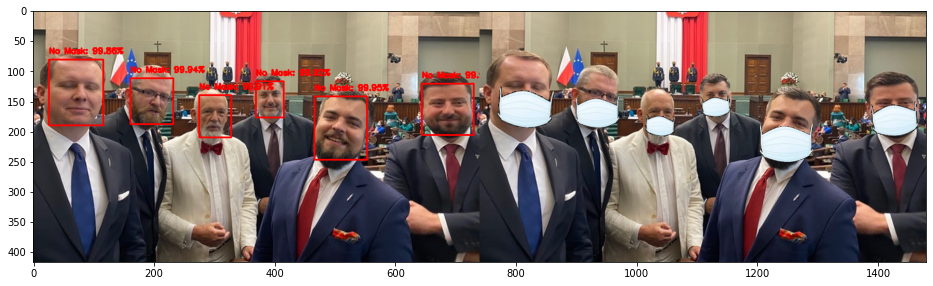

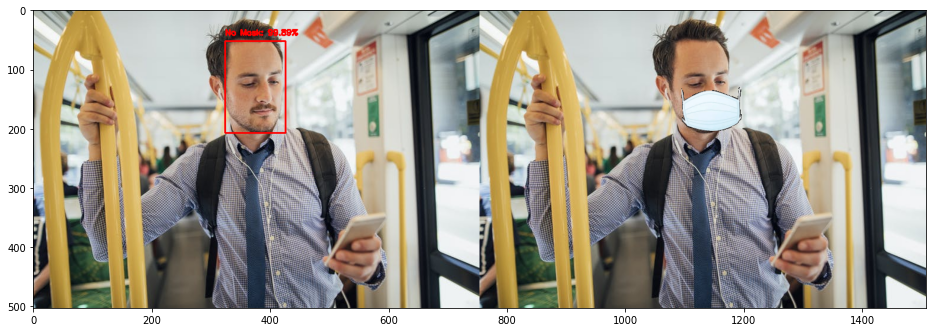

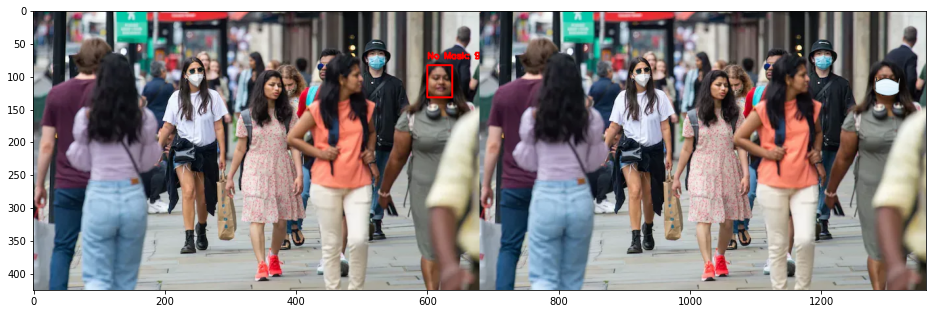

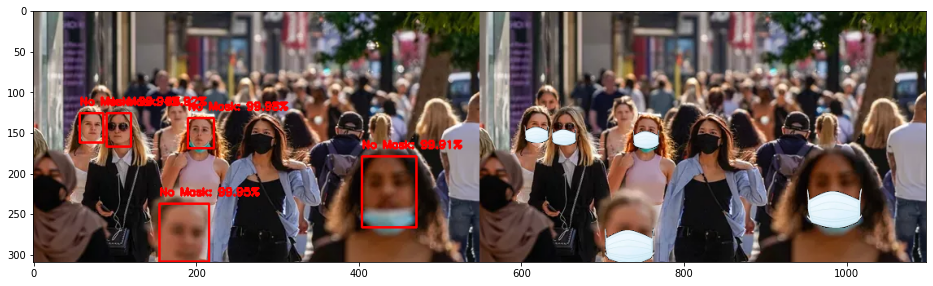

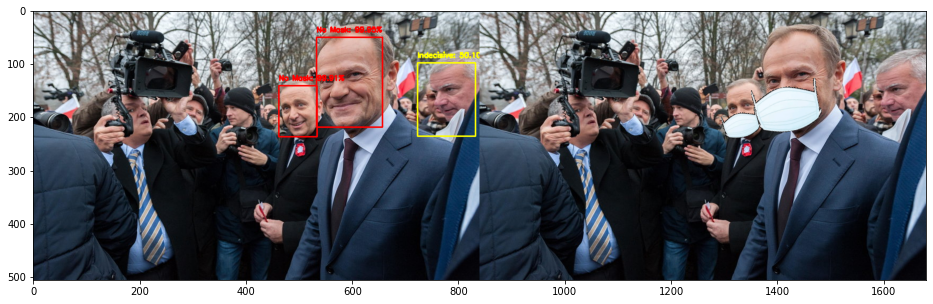

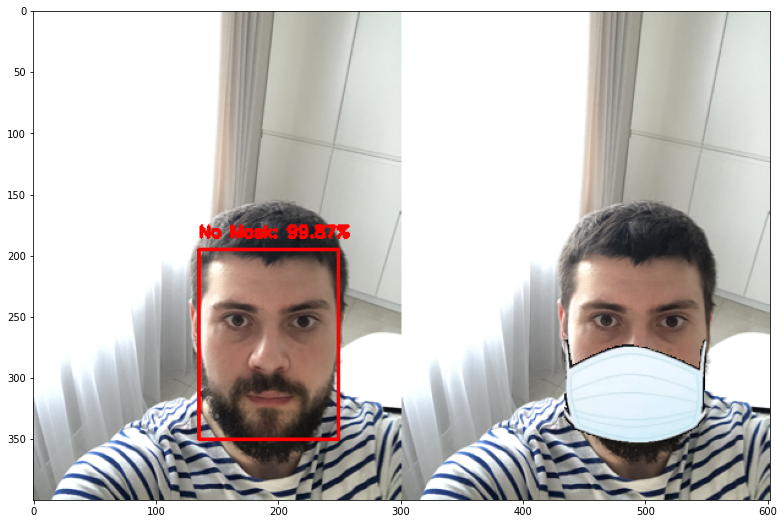

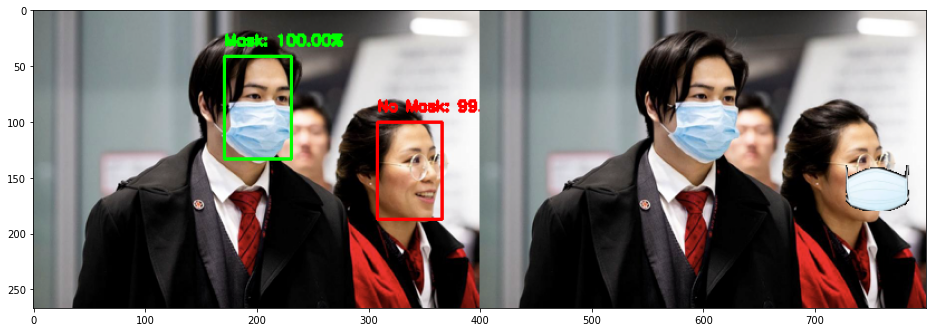

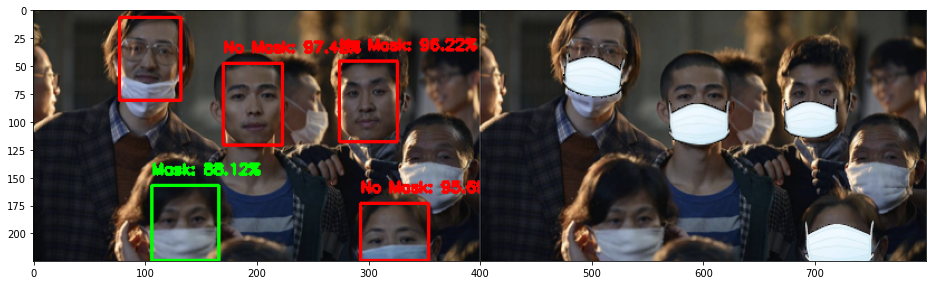

In [22]:
for file in onlyfiles:
    image = cv2.imread('./data_test/' + file)
    orig = image.copy()
    (h, w) = image.shape[:2]

    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),(104.0, 177.0, 123.0))
    net.setInput(blob)
    detections = net.forward()
    imageProcessing(detections, image)

# Bibliography

## Datasets

* https://data-flair.training/blogs/download-face-mask-data/
* https://www.kaggle.com/andrewmvd/face-mask-detection?select=annotations (for performence testing)